In [1]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time 
from scipy.stats import norm, laplace
from scipy.stats import anderson_ksamp, ks_2samp, shapiro
from scipy.optimize import curve_fit

In [2]:
np.random.seed(0)
file_path = "../csvs/resonant/"
planet_systems = np.loadtxt(file_path+"order.txt", dtype = str)

# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    except:
        probs = 0.00
    return probs
       
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    #print 
    return prob

In [3]:
np.random.seed(0)

delta_times = np.zeros((planet_systems.shape[0],3))

for jj, planet_sys in enumerate(planet_systems):
    try:
        times = pd.read_csv(file_path + planet_sys)
        delta_times[jj, 1:] = times["t"].values[:2]
        sys_id = planet_sys.split("_")[2]
        delta_times[jj, 0] = sys_id
    except:
        print ("Did not work for {0}".format(planet_sys))

In [4]:
deltatimes=pd.DataFrame(delta_times, columns=["ID","t", "t_shadow"])
deltatimes= deltatimes.sort_values("ID")
deltatimes.tail()

,ID,t,t_shadow
245,391.0,2.815414e+04,5.142078e+04
246,393.0,7.103793e+05,3.221912e+05
247,394.0,2.527237e+06,3.198412e+06
249,395.0,8.670889e+03,7.556106e+03
250,399.0,2.319745e+06,3.153388e+06


In [5]:
deltatimes.to_csv(file_path + "/deltatimes.csv", index=False)

In [6]:
# trim by same criteria to see which systems are left
trimmed = deltatimes[(deltatimes["t"]<1e7) & (deltatimes["t"]>1e4)
                    & (deltatimes["t_shadow"]<1e7)& (deltatimes["t_shadow"]>1e4)]
trimmed.shape

(184, 3)

In [7]:
nwalkers = 20
ndim = 2
iterations = 1000

sample_size = nwalkers*iterations*planet_systems.shape[0]
all_walker_samples=np.zeros((int(sample_size), 4)) 
values = np.zeros((planet_systems.shape[0], 7), dtype=str)
covariences = np.zeros((planet_systems.shape[0], ndim, ndim))

In [8]:
trimmed_ids = trimmed["ID"].values

In [9]:
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error", "Determinant"])
info.head()

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv(file_path+planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[2]
    print (sys_name)

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    
    # Run 200 steps as a burn-in.
    #print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    print ("Running MCMC ..."),
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=jj)
    end = time.time()
    print ("Done at ...", (end - start), "seconds.")

    #Determine the best mean and sigma
    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]
    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )
    covarience = np.cov([mean_samples, sigma_samples])
    print (covarience)
    determinant = np.linalg.det(covarience)
    print (determinant)
    covariences[jj, :, :] = covarience

    probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    
    #SAVE INFO OF INTEREST
    if np.exp(probability)>1:
        info.loc[jj] = [sys_name]+[np.inf]+[mean_fit, sigma_fit] + [np.inf]*3

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std, determinant]
    print (sys_name , probability, np.exp(probability),"\n")

0
Running MCMC ...
Done at ... 0.6568582057952881 seconds.
[[2.79954176e-04 8.87108001e-06]
 [8.87108001e-06 1.53256886e-04]]
4.282620909023659e-08
0 -0.740068778598825 0.4770811014229117 

100
Running MCMC ...
Done at ... 0.67051100730896 seconds.
[[6.45868877e-06 3.87199265e-08]
 [3.87199265e-08 3.39545774e-06]]
2.192870555547386e-11
100 1.1579130905067125 3.1832831156343846 

101
Running MCMC ...
Done at ... 0.6627604961395264 seconds.
[[ 5.91757152e-05 -2.77677941e-07]
 [-2.77677941e-07  3.04146228e-05]]
1.7997299523864898e-09
101 0.03923192085191751 1.0400116560719004 

102
Running MCMC ...
Done at ... 0.6552751064300537 seconds.
[[9.19463481e-04 3.00589149e-06]
 [3.00589149e-06 4.42257987e-04]]
4.066310329915849e-07
102 -1.3029142599694914 0.2717387207099144 

103
Running MCMC ...
Done at ... 0.648362398147583 seconds.
[[ 2.06935889e-04 -6.55009889e-08]
 [-6.55009889e-08  1.05400943e-04]]
2.1811233500142463e-08
103 -0.5548092265786859 0.5741817893729863 

104
Running MCMC ...
Don

In [10]:
info.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,0,0.477081,3.78758,0.375635,0.0167314,0.0123794,4.28262e-08
1,100,inf,4.88979,0.0568464,inf,inf,inf
2,101,inf,5.8658,0.174251,inf,inf,inf
3,102,0.271739,6.01699,0.670672,0.0303219,0.0210294,4.06631e-07
4,103,0.574182,3.87198,0.318449,0.0143849,0.0102662,2.18112e-08


In [11]:
info = info.astype("float64")
info = info.sort_values("ID")
info.to_csv(file_path + "Gaussian_Fits_{0}.csv".format(info.shape[0]),index=False)

trimmed_ids = trimmed["ID"].values
print (trimmed_ids[:4], type(trimmed_ids[0]), type(info.loc[0]["ID"]))
trimmed_info = info.loc[ info["ID"].isin(trimmed_ids) ]
print (trimmed_info.shape)

[3. 4. 5. 8.] <class 'numpy.float64'> <class 'numpy.float64'>
(184, 7)


In [12]:
trimmed_info.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
222,3.0,0.591132,6.837504,0.306543,0.013839,0.009772,1.828421e-08
256,4.0,0.763205,5.687568,0.239838,0.010566,0.007649,6.523258e-09
267,5.0,0.390180,5.797549,0.456784,0.020690,0.014837,9.424556e-08
300,8.0,0.430419,5.891151,0.417529,0.018658,0.013478,6.323880e-08
39,13.0,0.724655,4.644210,0.256174,0.011094,0.008051,7.978389e-09


In [13]:
#collect instability data for systems that fit the cut of being between 1e4 and 1e7 orbits
trimmed_systems = [x for x in planet_systems if int(x.split("_")[2]) in trimmed_ids ]

In [14]:
#do tests for only valid systems within the instability time range cuts

sig_levels_and = np.zeros(len(trimmed))
sig_levels_kstest = np.zeros(len(trimmed))
sig_levels_shapiro = np.zeros(len(trimmed))
ids = np.zeros(len(trimmed))

for jj, planet_sys in enumerate(trimmed_systems):

    np.random.seed(jj)
    data =pd.read_csv(file_path +planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    sys_name = float(planet_sys.split("_")[2])
    ids[jj] = sys_name
    index = np.where(sys_name==trimmed_info["ID"].values)[0][0]
    
    print(trimmed_info.iloc[index])
    # normal distribution we want to match, determined from MCMC analysis done above
    test = np.random.normal(loc=trimmed_info.iloc[index]["Mean"], scale=trimmed_info.iloc[index]["Sigma"], size = data.shape[0])

    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except:
        statistic, crit_val, sig_level = 0,0,0
    print (sys_name)
    
    print ("Anderson",  statistic,  crit_val, sig_level)
    sig_levels_and[jj] = sig_level
   
    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
        
    sig_levels_kstest[jj] = p_val
    print ("KS", statistic, p_val)
    
    try:
        statistic, p_val = shapiro(data)
    except:
        statistic, p_val = 0,0
        
    sig_levels_shapiro[jj] = p_val
    print ("Shapiro", statistic, p_val)

ID             100.000000
Probability           inf
Mean             4.889788
Sigma            0.056846
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 1, dtype: float64
100.0
Anderson 13.426774953701633 [0.325 1.226 1.961 2.718 3.752] 2.8601068118401605e-05
KS 0.146 3.9599420605401194e-05
Shapiro 0.8095924258232117 7.678782306613097e-24
ID             101.000000
Probability           inf
Mean             5.865803
Sigma            0.174251
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 2, dtype: float64
101.0
Anderson 2.2920137786856114 [0.325 1.226 1.961 2.718 3.752] 0.036642596479568926
KS 0.09799999999999998 0.015202766669802529
Shapiro 0.9720158576965332 3.526777447859786e-08
ID             1.080000e+02
Probability    4.989618e-01
Mean           6.590573e+00
Sigma          3.652152e-01
Mean_Error     1.659818e-02
Sigma_Error    1.123539e-02
Determinant    3.476667e-08
Name: 10, dtype: float64
108.0
Anderson -0

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


172.0
Anderson 2.598710063230539 [0.325 1.226 1.961 2.718 3.752] 0.02766353740428014
KS 0.07400000000000007 0.1237816725256176
Shapiro 0.9173641204833984 6.600979638720782e-16
ID             175.000000
Probability           inf
Mean             5.197803
Sigma            0.154140
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 85, dtype: float64
175.0
Anderson 2.55526309468087 [0.325 1.226 1.961 2.718 3.752] 0.02877901058486087
KS 0.09200000000000003 0.02713069416229015
Shapiro 0.956497311592102 5.5800176979037275e-11
ID             1.820000e+02
Probability    6.351611e-01
Mean           4.522281e+00
Sigma          2.864023e-01
Mean_Error     1.291163e-02
Sigma_Error    9.164476e-03
Determinant    1.399118e-08
Name: 92, dtype: float64
182.0
Anderson 9.064193917269728 [0.325 1.226 1.961 2.718 3.752] 0.00022354971272611478
KS 0.138 0.0001256035697452887
Shapiro 0.8838786482810974 6.231609605626159e-19
ID             1.870000e+02
Probability    3.833013e

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/scipy/stats/morestats.py:1323: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


ID             3.460000e+02
Probability    4.785870e-01
Mean           4.688835e+00
Sigma          3.823060e-01
Mean_Error     1.686046e-02
Sigma_Error    1.210169e-02
Determinant    4.161892e-08
Name: 218, dtype: float64
346.0
Anderson -0.22238117549353462 [0.325 1.226 1.961 2.718 3.752] 0.4392889682528606
KS 0.062 0.2828891626185374
Shapiro 0.9725902080535889 4.648633122883439e-08
ID             3.470000e+02
Probability    4.519712e-01
Mean           4.963525e+00
Sigma          4.033300e-01
Mean_Error     1.835768e-02
Sigma_Error    1.288941e-02
Determinant    5.599153e-08
Name: 219, dtype: float64
347.0
Anderson 17.90154533292591 [0.325 1.226 1.961 2.718 3.752] 9.437457827408207e-06
KS 0.182 9.823643570665105e-08
Shapiro 0.7865846157073975 4.641092051659003e-25
ID             3.480000e+02
Probability    4.505372e-01
Mean           5.833215e+00
Sigma          3.994531e-01
Mean_Error     1.815658e-02
Sigma_Error    1.280499e-02
Determinant    5.405915e-08
Name: 220, dtype: float64
348

In [15]:
scores = np.vstack([ ids, sig_levels_and, sig_levels_kstest, sig_levels_shapiro])
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P", "ShapiroW"] )
scores.head()

,ID,Anderson_P,KS_P,ShapiroW
0,100.0,0.000029,0.000040,7.678782e-24
1,101.0,0.036643,0.015203,3.526777e-08
2,108.0,0.390236,0.403103,5.864905e-06
3,109.0,0.687679,0.655550,3.596655e-06
4,113.0,0.032769,0.055479,7.397713e-13


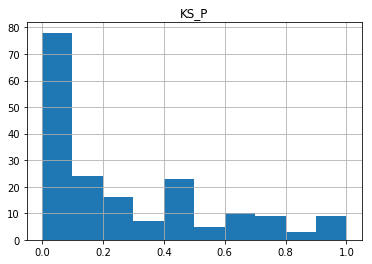

173


In [16]:
scores.hist("KS_P")
plt.show()
print (len(np.where(scores["KS_P"]>1e-6)[0]))
res_keep = scores[scores["KS_P"]>1e-6]
# interesting how we retain 173 out of 184 with the same cut
# we retain a significantly higher proportion, about 94% compared to with the randomly generated systems

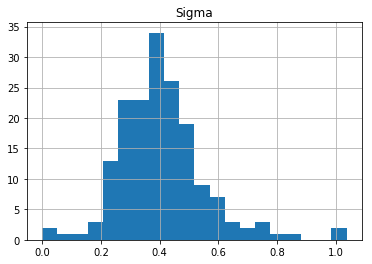

In [17]:
valid_gaus_params= trimmed_info[trimmed_info["ID"].isin((res_keep["ID"]).values)]
valid_gaus_params.hist("Sigma", bins = 20)
plt.show()

Average Sigma 0.40734287402647257 Std in Sigma 0.1486734452165868
Max valid sigma 1.035940966917217


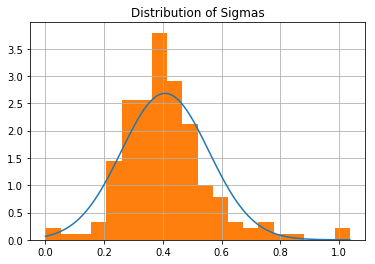

In [18]:
mu_fit, sig_fit =  norm.fit(valid_gaus_params["Sigma"].values)
print ("Average Sigma", mu_fit, "Std in Sigma", sig_fit)

fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, valid_gaus_params["Sigma"].max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = 20)

print("Max valid sigma", valid_gaus_params["Sigma"].max())
plt.title("Distribution of Sigmas")
plt.show()

In [19]:
norm_prob_sig = prob_sig/(prob_sig.sum())

Perform a convolution over the range of sigmas weighted by the likelihood of each sigma.

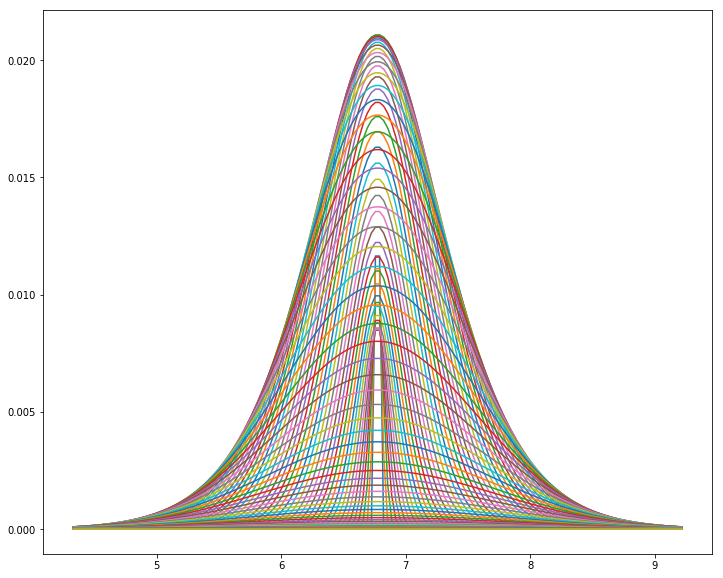

In [20]:
# Analytically over each of the mu;s, how to combine the sigmas?
max_sigma = mu_fit # the center of the distribution
increments = 150 

plt.figure(figsize=(12, 10))


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = np.log10(trimmed["t"].values[0])
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()

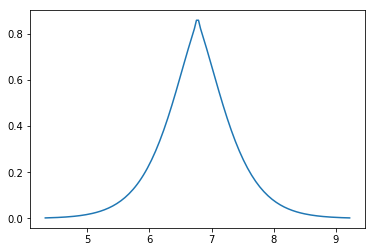

In [21]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
plt.show()

The laplace distribution has a mean of $\mu$, and a varience of $2b^2$.  P(x) = $\frac{1}{2b}exp(\frac{-|x-\mu|}{b})$

In [22]:
def laplace_fit(data, mean, spread):
    return np.exp(-np.abs(data-mean)/spread)/2./spread

[6.77428966 0.52063276]
[0.00354792 0.00502947]
params [0.         0.52063276]


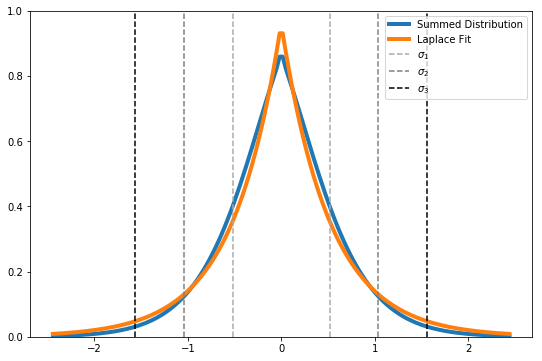

In [23]:
# Function for optimizing the difference between total_Y(graph from)

plt.figure (figsize=(9, 6))
popt, pcov = curve_fit(laplace_fit, bins, total_y)
print (popt)
perr = np.sqrt(np.diag(pcov))
print (perr)

# center distribution, as we're currently only interested in the spread
bins -= popt[0]
popt[0] = 0

plt.plot(bins, total_y, label = "Summed Distribution", linewidth = 4)
print("params", popt)


plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)


colors = ["darkgrey","grey", "black"]
for i in range(1,4):
    plt.axvline(popt[0]+i*popt[1], ls= "dashed", label = "$\sigma_{0}$".format(i), color = colors[i-1])
    plt.axvline(popt[0]-i*popt[1], ls= "dashed", color = colors[i-1])
plt.legend()
plt.ylim([0,1])
plt.show()

need the 10000 data samples before the next part can be done, which is taking all the delta times within our cuts and plotting that distribution


In [24]:
#try testing with the resonant dataset
res_test = pd.read_csv("../csvs/resonant/resonant_instability_times.csv", index_col=0)
res_test.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [25]:
test_samples = res_test[ (np.log10(res_test["instability_time"])<7 ) &
                       (np.log10(res_test["shadow_instability_time"])<7 ) &
                       (np.log10(res_test["instability_time"])>4 ) &
                       (np.log10(res_test["shadow_instability_time"])>4 ) ]
test_samples.shape

(5039, 10)

Laplacian params [0.         0.52063276]
Mean sig 0.40734287402647257


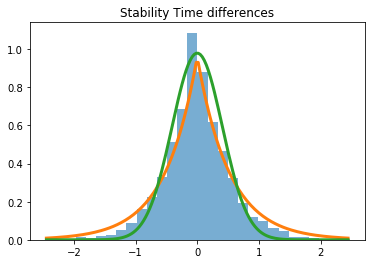

In [26]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
plt.hist(diff_data, bins= 30, normed=1, alpha = 0.6)

#plot with laplace fit
plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 3)
print("Laplacian params", popt[:])

#plot with gaussian with mean width
sig_plot = norm.pdf(bins, 0, mu_fit)
print("Mean sig", mu_fit)
plt.plot(bins, sig_plot, linewidth = 3)
plt.title("Stability Time differences")
plt.show()
